In [2]:
#RUN FIRST

curr_dir = f'/user_data/csimmon2/git_repos/ptoc'

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import ptoc_params as params

from plotnine import *

#hide warnings
import warnings
warnings.filterwarnings('ignore')

#load additional libraries
from nilearn import image, plotting, input_data, glm
from nilearn.input_data import NiftiMasker
import nibabel as nib
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
from nilearn.glm.first_level import compute_regressor 

suf = params.suf
#mni = load_mni152_brain_mask()



'''exp info'''
#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()

study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
exp = ''
#control_tasks = ['loc']
file_suf = ''

data_dir = params.data_dir
fig_dir = params.fig_dir
task_info = params.task_info
raw_dir = params.raw_dir

'''scan params'''
tr = 1 #toolloc_params
vols = 341 #toolloc_params

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

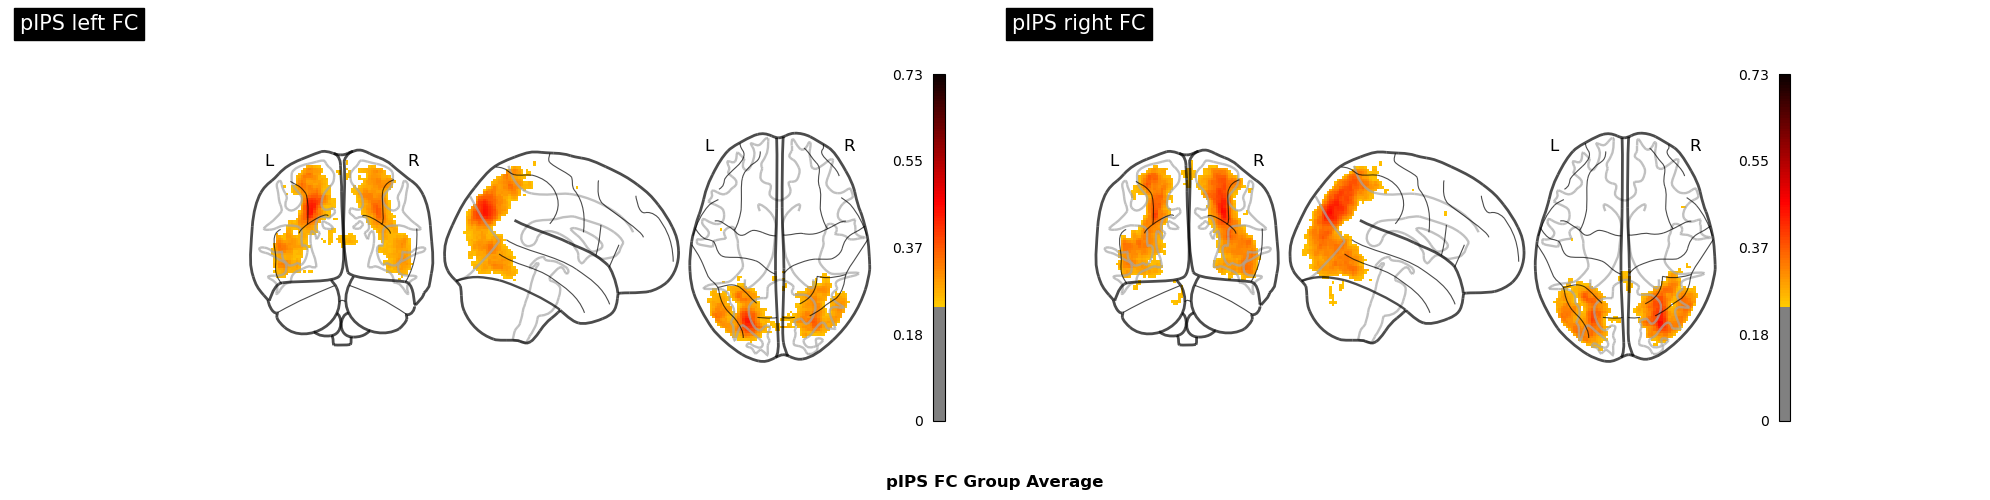

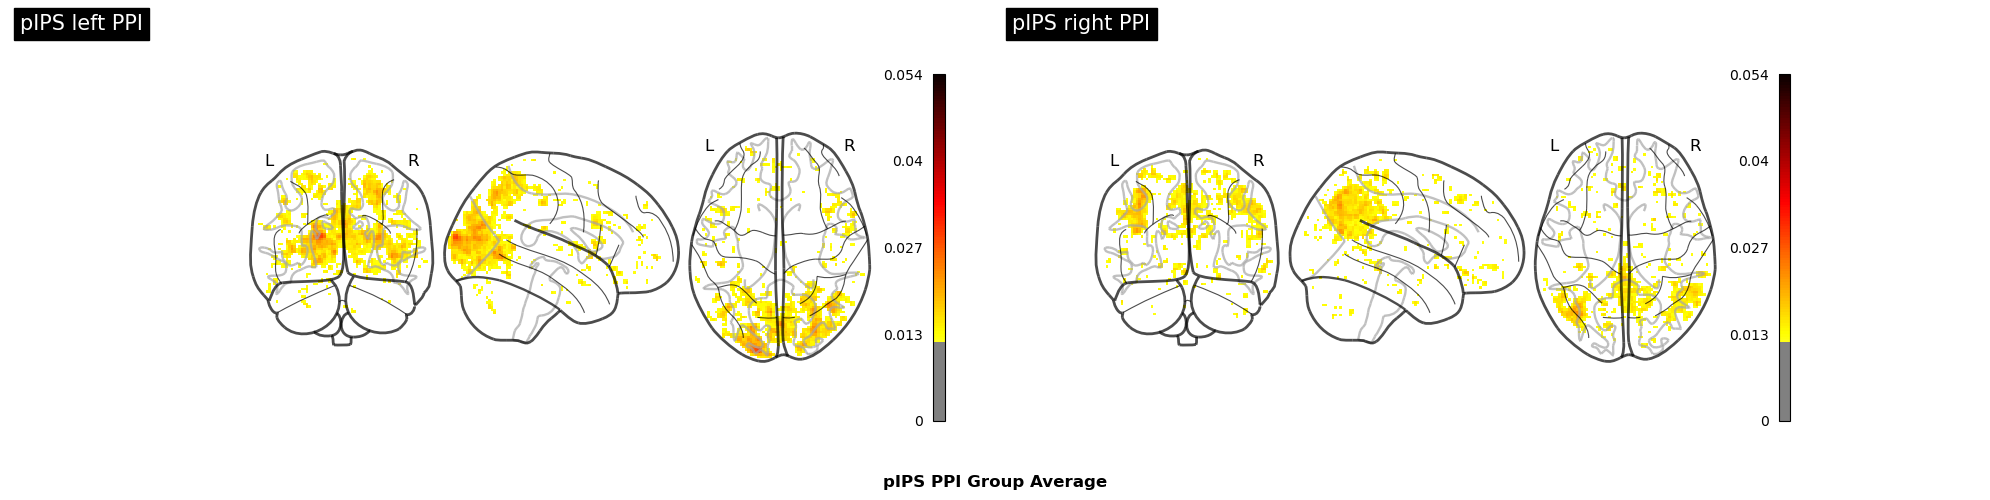

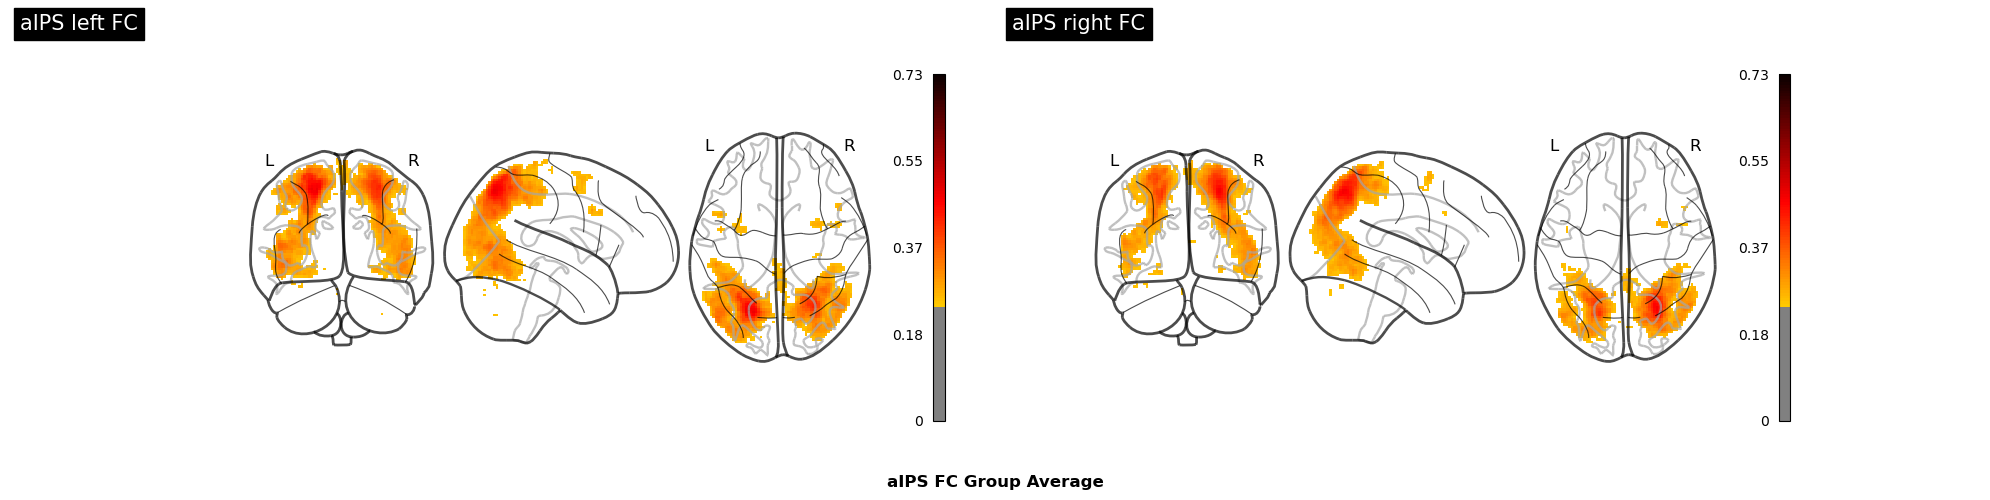

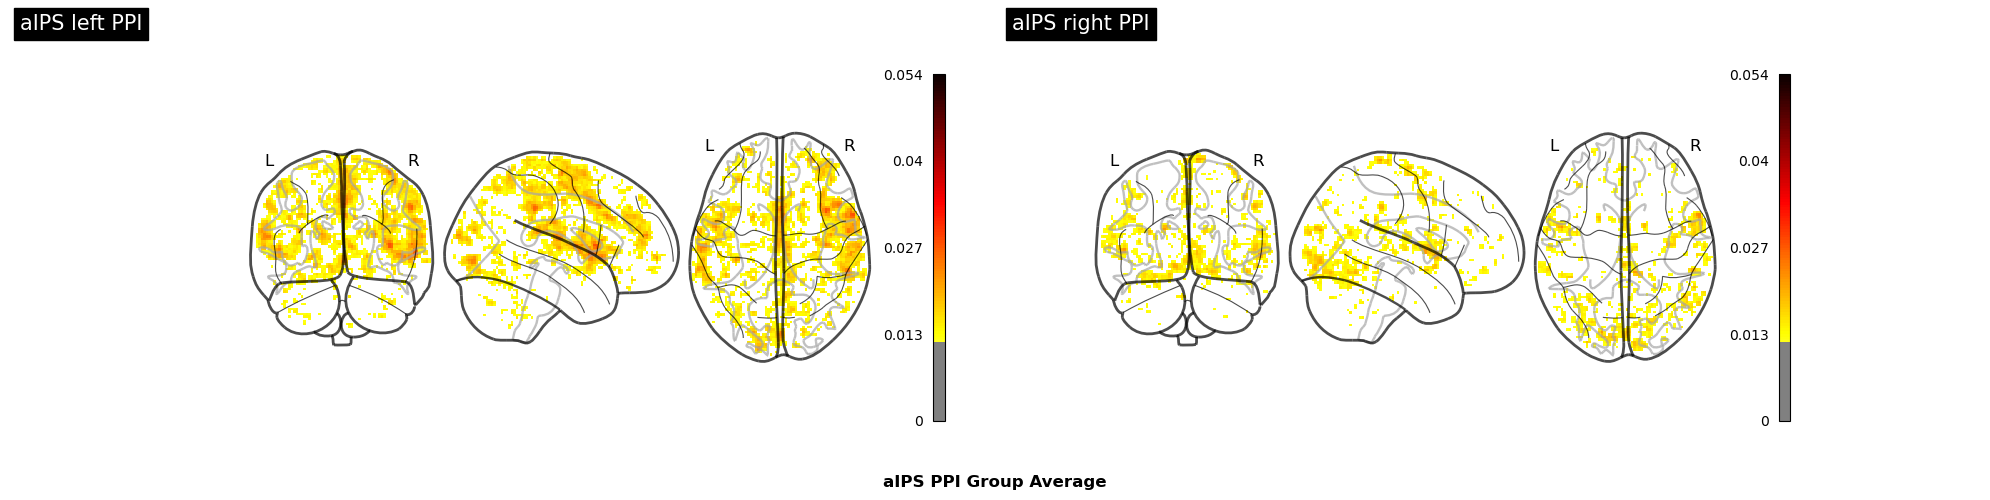

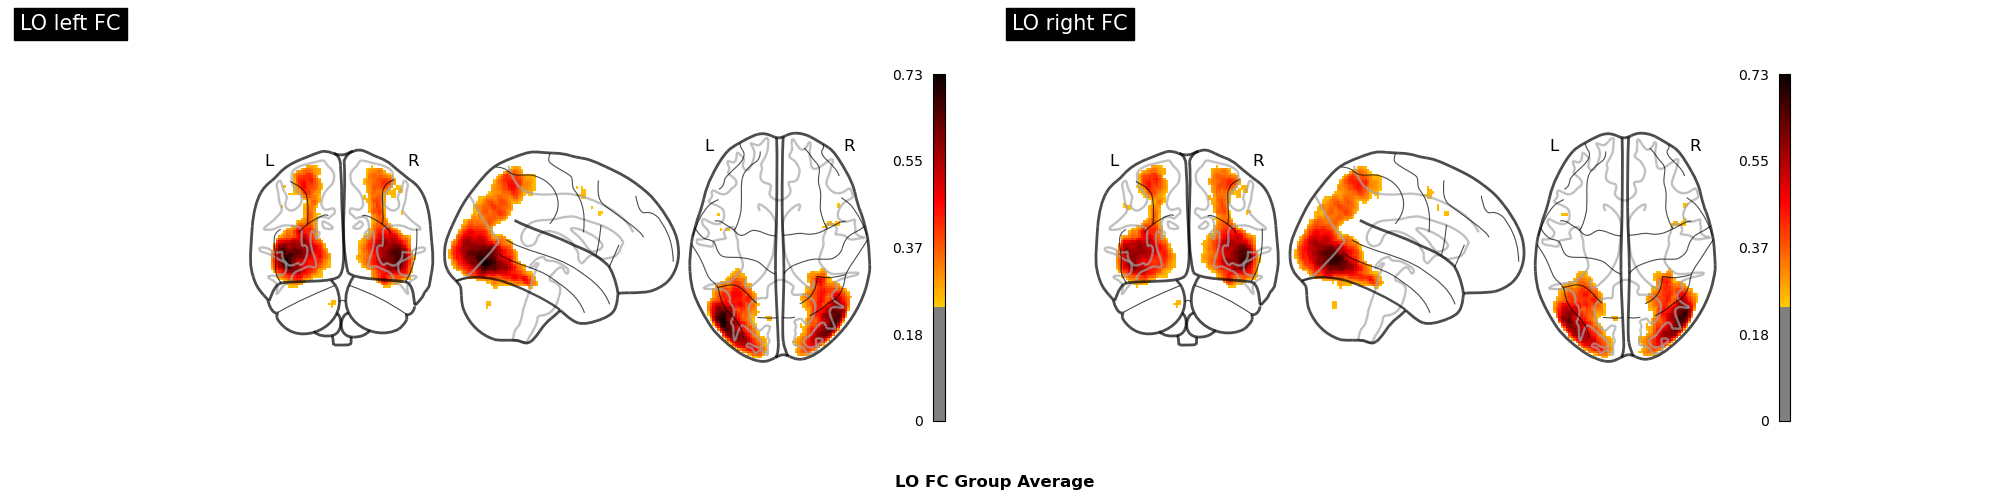

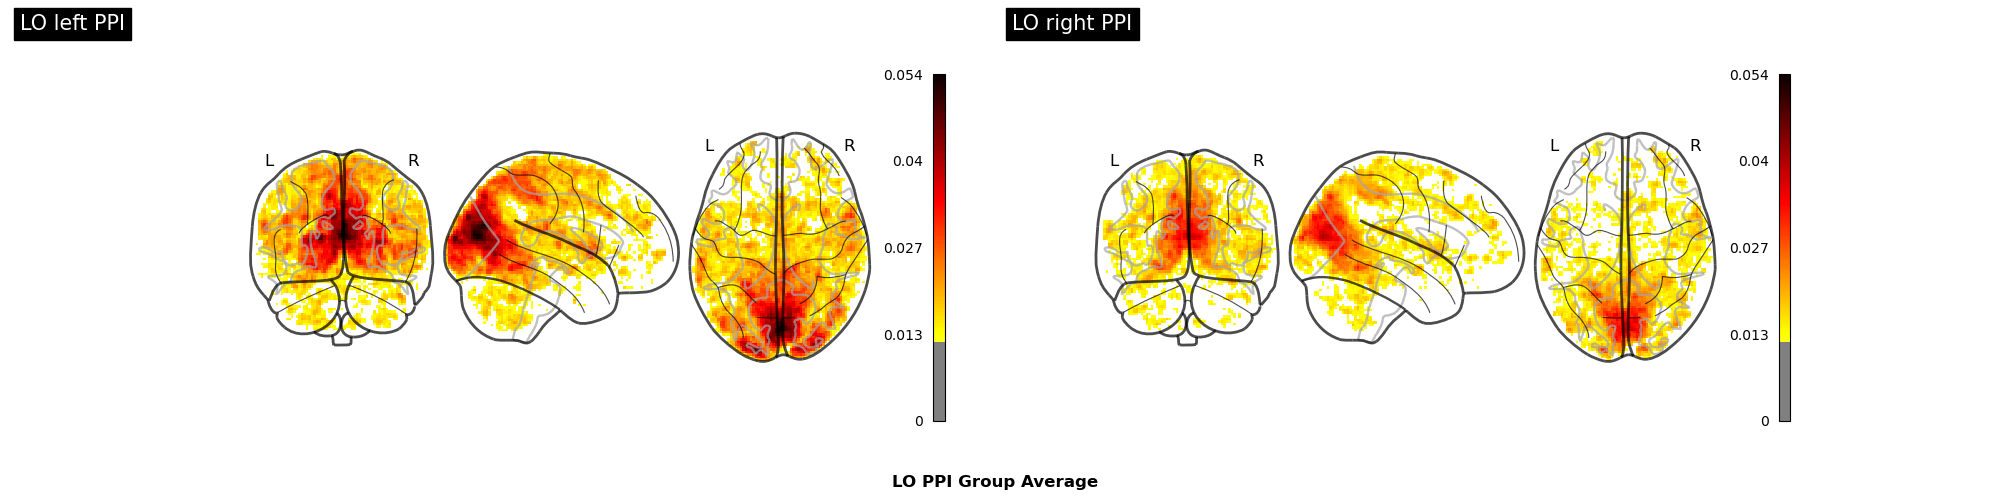

In [ ]:
# FC and PPI Brain Plots
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

# Define study directories
study_dir = "/lab_data/behrmannlab/vlad/ptoc"  # Updated to match registration script
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'
curr_dir = '/user_data/csimmon2/git_repos/ptoc'

# Explicitly set the path to sub_info.csv
sub_info_path = f'{curr_dir}/sub_info_tool.csv'

# Define subjects and ROIs
sub_info = pd.read_csv(sub_info_path)
subs = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
rois = ['pIPS', 'aIPS', 'LO']  # Updated to match registration script
hemispheres = ['left', 'right']

def create_group_averages(subs, rois, hemispheres, out_dir):
    for roi in rois:
        for hemi in hemispheres:
            for analysis_type in ['fc', 'ppi']:
                all_sub_imgs = []
                for sub in subs:
                    # Updated path to match registration script's MNI output directory
                    mni_dir = f"{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni"
                    img_file = f"{mni_dir}/{sub}_{roi}_{hemi}_ToolLoc_{analysis_type}_mni.nii.gz"
                    
                    if os.path.exists(img_file):
                        all_sub_imgs.append(image.load_img(img_file))
                    else:
                        print(f"Warning: File not found for {sub}, {roi}, {hemi}, {analysis_type}")
                
                if all_sub_imgs:
                    # Create and save average image if files were found
                    avg_img = image.mean_img(all_sub_imgs)
                    out_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                    nib.save(avg_img, out_file)
                    print(f"Successfully saved group average for {roi} {hemi} {analysis_type}")
                else:
                    print(f"No images found for {roi} {hemi} {analysis_type}")

def plot_group_averages(out_dir, rois, hemispheres):
    # Calculate separate max values for FC and PPI
    fc_max = 0
    ppi_max = 0
    
    # Find maximum values across all ROIs and hemispheres
    for roi in rois:
        for hemi in hemispheres:
            # Get FC max
            img_file = f'{out_dir}/{roi}_{hemi}_fc_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                fc_max = max(fc_max, np.abs(data).max())
            
            # Get PPI max
            img_file = f'{out_dir}/{roi}_{hemi}_ppi_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                ppi_max = max(ppi_max, np.abs(data).max())

    # Create plots for each ROI
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            
            # Set max value and threshold based on analysis type
            if analysis_type == 'fc':
                vmax = fc_max
                threshold = 0.25
            else:
                vmax = ppi_max
                threshold = 0.0125
            
            for i, hemi in enumerate(hemispheres):
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    display = plotting.plot_glass_brain(
                        img_file, 
                        threshold=threshold,
                        colorbar=True,
                        vmax=vmax, 
                        vmin=-vmax,
                        title=f'{roi} {hemi} {analysis_type.upper()}',
                        axes=axes[i],
                        display_mode='ortho'
                    )
            
            plt.tight_layout()
            fig.text(0.5, 0.01, f'{roi} {analysis_type.upper()} Group Average', 
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
            plt.subplots_adjust(bottom=0.15)
            #plt.savefig(f'{out_dir}/{roi}_{analysis_type}_group_average.png', dpi=300, bbox_inches='tight')
            #plt.close()

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Create group averages
    #create_group_averages(subs, rois, hemispheres, group_out_dir)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

In [ ]:
# TOOLS: Extract PPI connectivity values
sub_info = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv')
subs = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()

from multiprocessing import Pool
from functools import partial
import pandas as pd
from nilearn import input_data, image
import os

# Constants - adjust these as needed
output_dir = '/user_data/csimmon2/git_repos/ptoc/tools'  # for roi coordinates
derivatives_dir = '/lab_data/behrmannlab/vlad/ptoc'  # for PPI files
condition = 'tools'  # adjust as needed
run_combos = [[1,2], [2,1]]
rois = ['pIPS', 'aIPS', 'LO']
hemispheres = ['left', 'right']

def process_subject(ss, roi_coords):
    """Extract PPI values for a single subject"""
    results = []
    out_dir = f'{derivatives_dir}/{ss}/ses-01/derivatives'
    
    # Pre-compute all maskers for this subject
    maskers = {}
    for roi in rois:
        for hemi in hemispheres:
            prefix = hemi[0]
            for rcn, rc in enumerate(run_combos):
                coords = roi_coords[
                    (roi_coords['subject'] == ss) &
                    (roi_coords['run_combo'] == rcn) & 
                    (roi_coords['roi'] == f"{prefix}{roi}") &
                    (roi_coords['hemisphere'] == prefix) &
                    (roi_coords['condition'] == condition)
                ]
                if not coords.empty:
                    coords_xyz = [coords['x'].values[0], coords['y'].values[0], coords['z'].values[0]]
                    maskers[(roi, hemi, rcn)] = input_data.NiftiSpheresMasker(
                        [tuple(coords_xyz)], 
                        radius=6,
                        standardize=False
                    )

    # Process all combinations
    for seed_roi in rois:
        for seed_hemi in hemispheres:
            for target_roi in rois:
                for target_hemi in hemispheres:
                    if seed_roi == target_roi and seed_hemi == target_hemi:
                        continue

                    for rcn, rc in enumerate(run_combos):
                        target_key = (target_roi, target_hemi, rcn)
                        if target_key not in maskers:
                            continue

                        # Load PPI file - adapts for nontools condition
                        if condition == 'nontools':
                            ppi_file = f'{out_dir}/ppi/{ss}_{seed_roi}_{seed_hemi}_{condition}_ToolLoc_ppi_run{rc[0]}to{rc[1]}.nii.gz'
                        else:  # for tools
                            ppi_file = f'{out_dir}/ppi/{ss}_{seed_roi}_{seed_hemi}_ToolLoc_ppi_run{rc[0]}to{rc[1]}.nii.gz'
                            
                        try:
                            ppi_img = image.load_img(ppi_file)
                            ppi_value = maskers[target_key].fit_transform(ppi_img).mean()
                            results.append({
                                'subject': ss,
                                'seed_roi': seed_roi,
                                'seed_hemi': seed_hemi,
                                'target_roi': target_roi,
                                'target_hemi': target_hemi,
                                'run_combo': f"{rc[0]}to{rc[1]}",
                                'value': ppi_value
                            })
                        except Exception as e:
                            print(f"Error processing {ppi_file}: {str(e)}")
                            continue
                            
    return results

# Read coordinates
roi_coords = pd.read_csv(f'{output_dir}/roi_coordinates.csv')

# Create partial function with fixed arguments
process_func = partial(process_subject, roi_coords=roi_coords)

# Process subjects in parallel
with Pool() as pool:
    all_results = pool.map(process_func, subs)

# Flatten results and create DataFrame
all_results = [item for sublist in all_results for item in sublist]
ppi_df = pd.DataFrame(all_results)

# Save results
ppi_df.to_csv(f'{output_dir}/roi_ppi_sphere_summary_{condition}.csv', index=False)

In [3]:
# NON_TOOLS: Extract PPI connectivity
from multiprocessing import Pool
from functools import partial
import pandas as pd
from nilearn import input_data, image
import os

sub_info = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv')
subs = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()

# Constants - adjust these as needed
output_dir = '/user_data/csimmon2/git_repos/ptoc/tools'  # for roi coordinates
derivatives_dir = '/lab_data/behrmannlab/vlad/ptoc'  # for PPI files
condition = 'nontools'  # adjust as needed
run_combos = [[1,2], [2,1]]
rois = ['pIPS', 'aIPS', 'LO']
hemispheres = ['left', 'right']

def process_subject(ss, roi_coords):
    """Extract PPI values for a single subject"""
    results = []
    out_dir = f'{derivatives_dir}/{ss}/ses-01/derivatives'
    
    # Pre-compute all maskers for this subject
    maskers = {}
    for roi in rois:
        for hemi in hemispheres:
            prefix = hemi[0]
            for rcn, rc in enumerate(run_combos):
                coords = roi_coords[
                    (roi_coords['subject'] == ss) &
                    (roi_coords['run_combo'] == rcn) & 
                    (roi_coords['roi'] == f"{prefix}{roi}") &
                    (roi_coords['hemisphere'] == prefix) &
                    (roi_coords['condition'] == condition)
                ]
                if not coords.empty:
                    coords_xyz = [coords['x'].values[0], coords['y'].values[0], coords['z'].values[0]]
                    maskers[(roi, hemi, rcn)] = input_data.NiftiSpheresMasker(
                        [tuple(coords_xyz)], 
                        radius=6,
                        standardize=False
                    )

    # Process all combinations
    for seed_roi in rois:
        for seed_hemi in hemispheres:
            for target_roi in rois:
                for target_hemi in hemispheres:
                    if seed_roi == target_roi and seed_hemi == target_hemi:
                        continue

                    for rcn, rc in enumerate(run_combos):
                        target_key = (target_roi, target_hemi, rcn)
                        if target_key not in maskers:
                            continue

                        # Load PPI file - adapts for nontools condition
                        if condition == 'nontools':
                            ppi_file = f'{out_dir}/ppi/{ss}_{seed_roi}_{seed_hemi}_{condition}_ToolLoc_ppi_run{rc[0]}to{rc[1]}.nii.gz'
                            
                        try:
                            ppi_img = image.load_img(ppi_file)
                            ppi_value = maskers[target_key].fit_transform(ppi_img).mean()
                            results.append({
                                'subject': ss,
                                'seed_roi': seed_roi,
                                'seed_hemi': seed_hemi,
                                'target_roi': target_roi,
                                'target_hemi': target_hemi,
                                'run_combo': f"{rc[0]}to{rc[1]}",
                                'value': ppi_value
                            })
                        except Exception as e:
                            print(f"Error processing {ppi_file}: {str(e)}")
                            continue
                            
    return results

# Read coordinates
roi_coords = pd.read_csv(f'{output_dir}/roi_coordinates.csv')

# Create partial function with fixed arguments
process_func = partial(process_subject, roi_coords=roi_coords)

# Process subjects in parallel
with Pool() as pool:
    all_results = pool.map(process_func, subs)

# Flatten results and create DataFrame
all_results = [item for sublist in all_results for item in sublist]
ppi_df = pd.DataFrame(all_results)

# Save results
ppi_df.to_csv(f'{output_dir}/roi_ppi_sphere_summary_{condition}.csv', index=False)

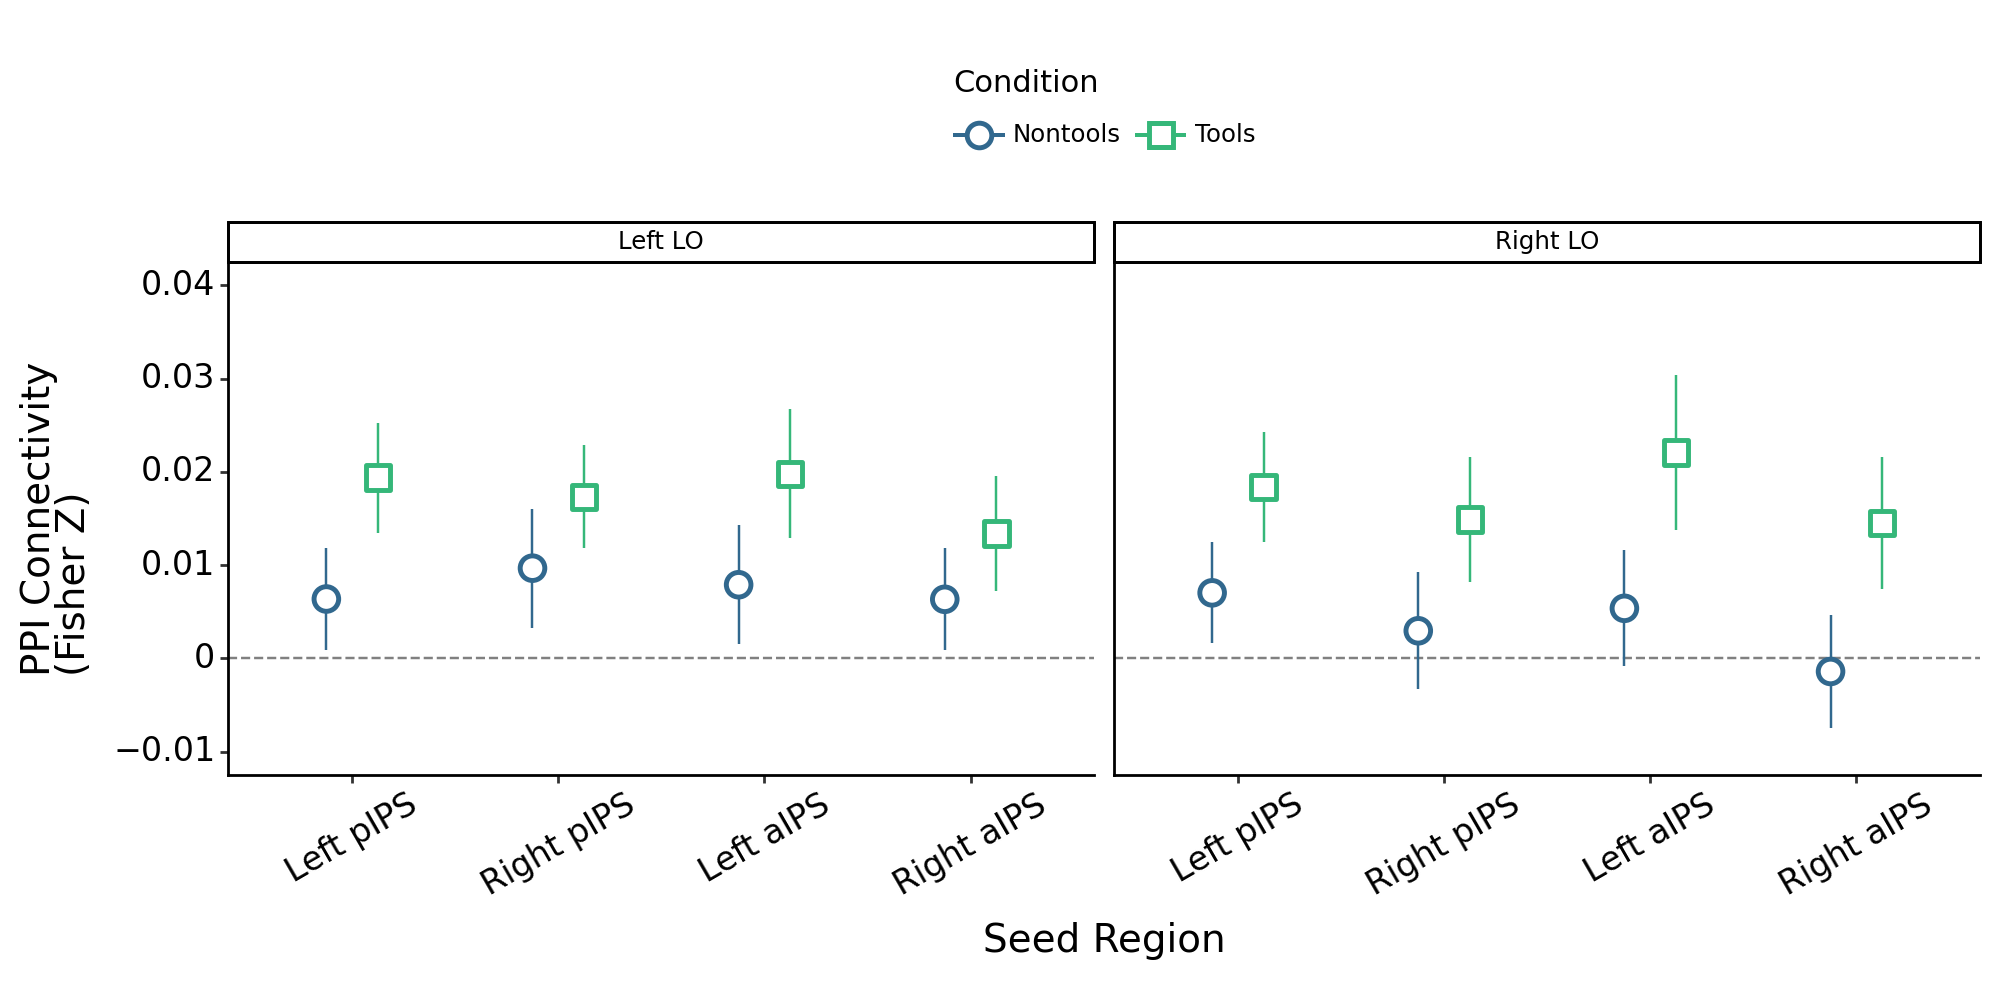

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 5 in image.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /user_data/csimmon2/git_repos/ptoc/tools/combined_lo_connectivity_both_conditions.png



Full data:
          Seed    Target Condition        FC        SE      ymin      ymax
8    Left pIPS   Left LO  Nontools  0.006357  0.005442  0.000915  0.011799
9    Left pIPS   Left LO     Tools  0.019355  0.005874  0.013481  0.025229
12  Right pIPS   Left LO  Nontools  0.009662  0.006383  0.003278  0.016045
13  Right pIPS   Left LO     Tools  0.017313  0.005522  0.011791  0.022834
0    Left aIPS   Left LO  Nontools  0.007885  0.006394  0.001491  0.014280
1    Left aIPS   Left LO     Tools  0.019779  0.006921  0.012857  0.026700
4   Right aIPS   Left LO  Nontools  0.006325  0.005477  0.000849  0.011802
5   Right aIPS   Left LO     Tools  0.013371  0.006150  0.007221  0.019521
10   Left pIPS  Right LO  Nontools  0.007017  0.005428  0.001588  0.012445
11   Left pIPS  Right LO     Tools  0.018372  0.005907  0.012465  0.024278
14  Right pIPS  Right LO  Nontools  0.002948  0.006282 -0.003334  0.009229
15  Right pIPS  Right LO     Tools  0.014870  0.006681  0.008189  0.021551
2    Left aIP

In [ ]:
# PPI combined plot
import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_linerange, geom_point, ylim, 
                    theme_classic, xlab, ylab, theme, element_text, 
                    element_line, element_blank, facet_wrap, scale_color_manual,
                    scale_shape_manual, position_dodge, geom_hline)

# Define paths
output_dir = '/user_data/csimmon2/git_repos/ptoc/tools'

# Read both conditions
tools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_tools.csv")
nontools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_nontools.csv")

# Add condition column to each
tools_df['condition'] = 'Tools'
nontools_df['condition'] = 'Nontools'

# Combine dataframes
df = pd.concat([tools_df, nontools_df])

# Filter out LO seeds and keep only LO targets
df = df[~df['seed_roi'].isin(['LO'])]
df = df[df['target_roi'] == 'LO']

# Create seed and target columns
df['seed'] = df['seed_roi'] + '_' + df['seed_hemi']
df['target'] = df['target_roi'] + '_' + df['target_hemi']

# Calculate group-level statistics
group_summary = (df.groupby(['seed', 'target', 'condition'])
               .agg({
                   'value': ['mean', 'sem']
               })
               .reset_index())
group_summary.columns = ['Seed', 'Target', 'Condition', 'FC', 'SE']

# Calculate error bar limits
group_summary['ymin'] = group_summary['FC'] - group_summary['SE']
group_summary['ymax'] = group_summary['FC'] + group_summary['SE']

# Map to descriptive names
seed_mapping = {
   'pIPS_left': 'Left pIPS',
   'pIPS_right': 'Right pIPS',
   'aIPS_left': 'Left aIPS',
   'aIPS_right': 'Right aIPS'
}
target_mapping = {
   'LO_left': 'Left LO',
   'LO_right': 'Right LO'
}

group_summary['Seed'] = group_summary['Seed'].map(seed_mapping)
group_summary['Target'] = group_summary['Target'].map(target_mapping)

# Set Seed order
group_summary['Seed'] = pd.Categorical(
   group_summary['Seed'], 
   categories=['Left pIPS', 'Right pIPS', 'Left aIPS', 'Right aIPS'],
   ordered=True
)

dodge = position_dodge(width=0.5)

# Create plot
plot = (ggplot(group_summary)
        + geom_hline(yintercept=0, linetype='dashed', color='gray', size=0.5)  # Add zero line
        + geom_linerange(aes(x='Seed', ymin='ymin', ymax='ymax', color='Condition'), 
                      size=.5, position=dodge)
        + geom_point(aes(x='Seed', y='FC', color='Condition', shape='Condition'), 
                    size=4, fill='white', stroke=1,
                    position=dodge)
        + facet_wrap('~Target', nrow=1)
        + theme_classic()
        + xlab('Seed Region')
        + ylab('PPI Connectivity\n(Fisher Z)')
        + ylim(-0.01, 0.04)
        + scale_color_manual(values=['#31688E', '#35B779'])
        + scale_shape_manual(values=['o', 's'])
        + theme(
            text=element_text(color='black'),
            axis_text_x=element_text(angle=30, size=12),
            axis_text_y=element_text(size=12),
            axis_title=element_text(size=14),
            axis_line=element_line(),
            panel_border=element_blank(),
            legend_position="top",
            figure_size=(10, 5)
        ))

# Save plot
print(plot)
plot.save(f"{output_dir}/combined_lo_connectivity_both_conditions.png", dpi=300)

# Print summary statistics
print("\nFull data:")
print(group_summary.sort_values(['Target', 'Seed', 'Condition']))